In [ ]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [ ]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *


In [ ]:
import nbs.orelm_torch as orelm

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [ ]:
import nbs_pipeline.utils.config as cfg
config, job_type = cfg.get_artifact_config_DCAE(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02b-encoder_dcae.yaml
... About to replace includes with content
Antes de leer configuration {'include': None, 'user_preferences': {'use_wandb': False, 'wdb': {'user': 'mi-santamaria', 'project_name': 'test-project', 'version': '0', 'mode': 'offline', 'artifacts_path': './data/wandb_artifacts'}, 'data': {'folder': '~/data/', 'fname': 'Semantic_Segmentation_TiltABP', 'ftype': '.csv', 'cols': [], 'freq': '1s'}, 'artifact': {'alias': 'TiltABP'}, 'directories': {'tmp': 'tmp', 'data': '~/data/Semantic_Segmentation_TiltABP.csv'}}, 'data': {'name': 'Semantic_Segmentation_TiltABP', 'path': '~/data/Semantic_Segmentation_TiltABP.csv', 'alias': 'TiltABP', 'cols': [], 'csv_config': {}, 'date_offset': None, 'date_format': '%Y-%m-%d %H:%M:%S', 'freq': '1s', 'joining_train_test': False, 'missing_values': {'technique': None, 'constant': None}, 'normalize_training': False, 'range_training': None, 'range_testing': None, 'resampling_freq': None, 'start_

In [ ]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [ ]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [ ]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

wandb:   1 of 1 files downloaded.  


((40000, 2), (39969, 2, 32))

In [ ]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape

## Extract important features from the multivariate time series data through Deep Convolutional Autoencoders


Deep Convolutional Auto Encoders (DCAE) is a powerful method for learning high-level and mid-level abstractions from low-level raw data. It has the ability to extract features from complex and large time-series in an unsupervised manner. This is useful to overcome the complexity of multivariate time-series.

Compared to the conventional auto-encoder, DCAE has fewer parameters than the conventional auto-encoder which means less training time. Also, DCAE uses local information to reconstruct the signal while conventional auto-encoders utilize fully connected layers to globally do the reconstruction. DCAE is an unsupervised model for representation learning which maps inputs into a new representation space. It has two main parts which are the encoding part that is used to project the data into a set of feature spaces and the decoding part that reconstructs the original data. The latent space representation is the space where the data lie in the bottleneck layers.

The loss function of the DCAE is defined as the error between the input and the output. DCAE aims to find a code for each input by minimizing the mean squared error (MSE) between its input (original data) and output (reconstructed data). The MSE is used which assists to minimize the loss; thus, the network is forced to learn a low-dimensional representation of the input.

We will implement the DCAE of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y), whose architecture is shown in the table below:

![](https://i.imgur.com/3EjuAfQ.png)

Note that, in the paper, the input shape is $60 \times 3$, due to multivariate time series has 3 variables and the window size is 60. Generally, the size of the input/output of the autoencoder will depend on the shape of each slice obtained in the previos step. The number of latent features to be discovered is $60$ in the table above, but we can consider this as a free hyperparameter $\delta$. Also, according to the paper: "*The number of feature maps, size of filter and depth of the model are set based on the reconstruction error on validation set.*". Thus, we must provide flexibility in the creation of the DCAE in terms of these hyperparameters.º

In case you are not using a config file, you can also uncomment the following cell and define the hyperparameters in the fly

In [ ]:
all_equal([len(x) for x in [config.nfs, config.kss, config.pool_szs]], 
          np.repeat(len(config.nfs), 3))

True

### Create the model

The implementation of the DCAE is done using Keras.

In [ ]:
m = DCAE_torch(c_in=X_train.shape[1], seq_len=config.w, delta=config.delta, 
               pool_szs=config.pool_szs, nfs=config.nfs)
print(m)
foo = torch.rand(1, X_train.shape[1], config.w)
foo.shape, m(foo).shape

DCAE_torch(
  (downsample): Sequential(
    (0): SameConv1d(
      (conv1d_same): Conv1d(2, 64, kernel_size=(10,), stride=(1,))
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_in): Linear(in_features=32, out_features=60, bias=True)
    (latent_out): Linear(in_features=60, out_features=32, bias=True)
    (reshape): Reshape(bs, 16, 2)
  )
  (upsample): Sequential(
    (0): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Upsample(scale_factor=4.0, mode=nearest)
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3)

(torch.Size([1, 2, 32]), torch.Size([1, 2, 32]))

Train the model with fastai Learner class, to abstract from Pytorch's training loop

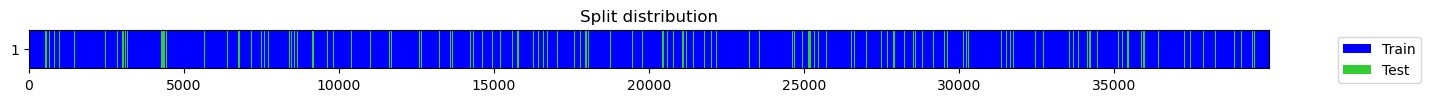

((#35973) [23599,13690,11927,1588,92,38300,16269,5287,21820,32703...],
 (#3996) [37732,18242,28645,21198,30186,7762,38713,16435,3918,2943...])

In [ ]:
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits

(<Axes: >, <Axes: >)

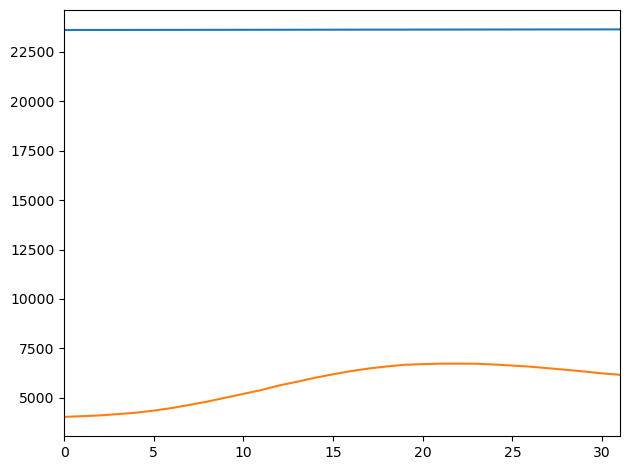

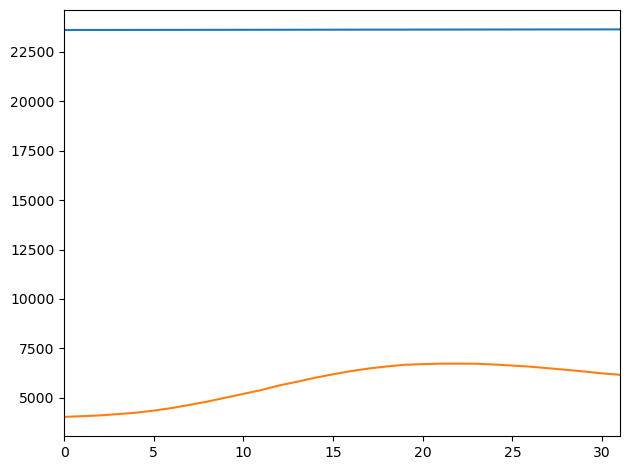

In [ ]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset[0][0].show(), ToTSTensor()(dls.dataset[0][1]).show()

epoch,train_loss,valid_loss,time
0,49553684.000000,48142552.000000,00:07
1,43969328.000000,43455192.000000,00:07
2,43207780.000000,41540920.000000,00:07
3,40007012.000000,44412352.000000,00:07
4,34216692.000000,32397200.000000,00:06
5,32027826.000000,30413760.000000,00:07
6,30704928.000000,28652402.000000,00:06
7,28754008.000000,28886698.000000,00:06
8,27591330.000000,26382326.000000,00:06
9,26628380.000000,26585696.000000,00:07


... Enabling Vs Code execution ...


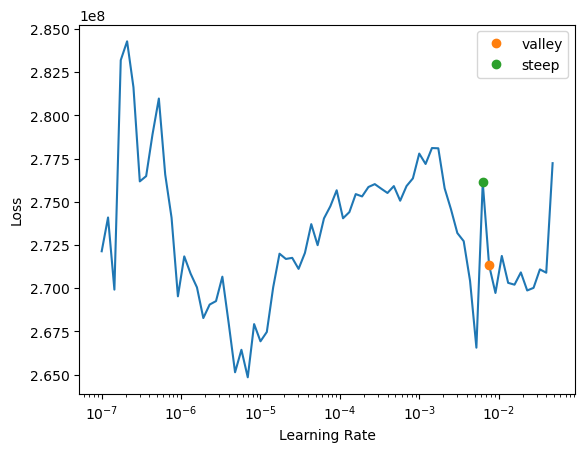

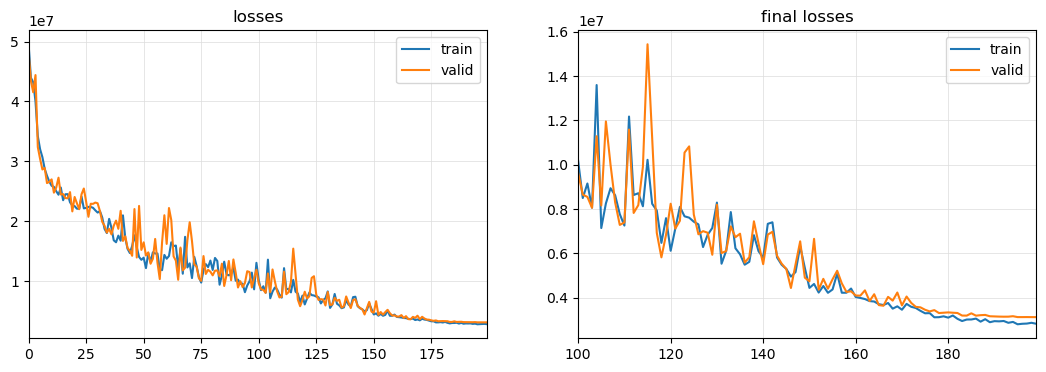

In [ ]:
m = DCAE_torch(c_in=X_train.shape[1], seq_len=config.w, delta=config.delta, 
               pool_szs=config.pool_szs, nfs=config.nfs)
learn = Learner(dls=dls, model=m, loss_func=nn.MSELoss(), opt_func=Adam, 
                cbs=[WandbCallback(log_preds=False)])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep])
learn.fit_one_cycle(config.epochs, lr_max=lr_valley)
learn.plot_metrics()




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [ ]:
aux_learn = learn.export_and_get()
if config.use_wandb: 
    ar = ReferenceArtifact(aux_learn, f'dcae', type='learner', metadata=dict(run.config))
    run.log_artifact(ar, aliases=f'run-{run.project}-{run.id}')

## Baseline models (To rewrite)

Calculate baseline models taking into account that the best prediction is the average and median value of each of the windows

## Validate the autoencoder

Let's validate the autoencoder quality visually:

#### Get the best and the worst k predictions using the autoencoder

In [ ]:
interp = Interpretation.from_learner(learn)

... Enabling Vs Code execution ...


In [ ]:
top_losses = interp.top_losses(3)
top_losses

(tensor([4.4243e+08, 1.1463e+08, 1.0562e+08]), tensor([ 205, 1962, 1489]))

In [ ]:
#for i in top_losses.indices: dls.dataset[i][0].show()

In [ ]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▅▅▄▄▅▃▅▃▄▂▃▃▄▃▂▃▂▂▂▂▂▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_samples_per_sec,▇▇█▅▇██▇▇▇███▇▇▇▇▇████▇▇▇▇▇▇▅▇▆▇▇▇▁▇█▇██
valid_loss,█▆▅▅▄▄▄▄▃▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
